In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon
from shapely.affinity import rotate, translate
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from tqdm import tqdm
import statsmodels.api as sm
from pathlib import Path

In [2]:
Path("figs").mkdir(exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)

In [3]:
gdf = gpd.read_file("data/interim/singapore_coastline_3414.gpkg", layer="coast")
gdf = gdf.set_geometry("geom" if "geom" in gdf.columns else "geometry")

In [4]:
def _vertex_spacings_line(line):
    xs, ys = line.coords.xy
    dx = np.diff(xs)
    dy = np.diff(ys)
    return np.hypot(dx, dy)

In [5]:
spacings = []
for geom in gdf.geometry:
    if geom is None:
        continue
    if geom.geom_type == "LineString":
        spacings += list(_vertex_spacings_line(geom))
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            if part.geom_type == "LineString":
                spacings += list(_vertex_spacings_line(part))
spacings = np.asarray(spacings)

In [6]:
stats = {
    "n_segments": spacings.size,
    "min_spacing_m": float(np.min(spacings)),
    "median_spacing_m": float(np.median(spacings)),
    "p90_spacing_m": float(np.percentile(spacings, 90)),
}
stats

{'n_segments': 39,
 'min_spacing_m': 493.280124506551,
 'median_spacing_m': 2395.7287785551007,
 'p90_spacing_m': 3685.295053855384}

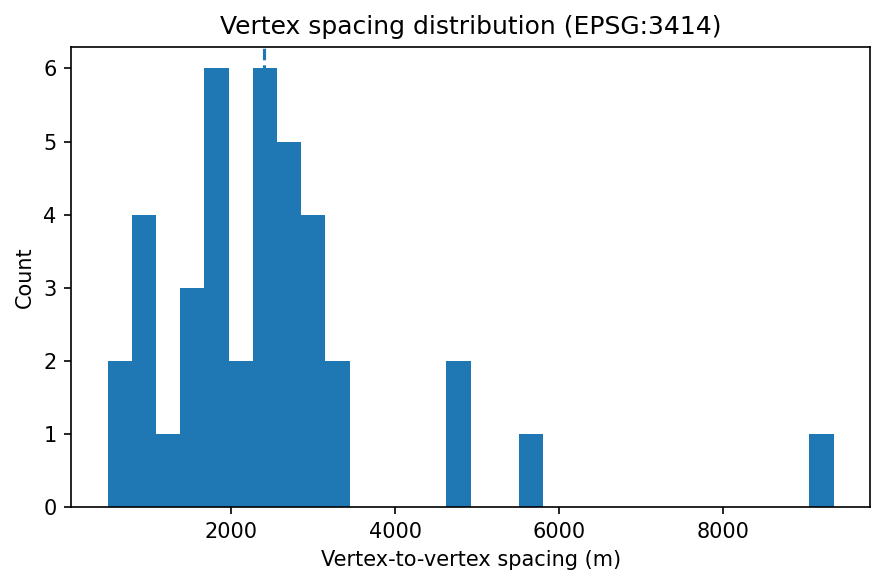

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.hist(spacings, bins=30)
ax.axvline(np.median(spacings), linestyle="--")
ax.set_xlabel("Vertex-to-vertex spacing (m)")
ax.set_ylabel("Count")
ax.set_title("Vertex spacing distribution (EPSG:3414)")
plt.tight_layout()
plt.savefig("figs/spacing_hist.png", dpi=300)
plt.show()

In [8]:
def build_eps_ladder(spacings, bounds, factor=3.0, min_floor=300.0, target_len=6):
    median_spacing = float(np.median(spacings))
    eps_min = max(factor * median_spacing, min_floor)

    minx, miny, maxx, maxy = bounds
    span = max(maxx - minx, maxy - miny)
    eps_max = max(span / 2.0, eps_min * 1.5)

    arr = []
    e = eps_max
    while e >= eps_min:
        arr.append(round(e, -1))
        e *= 0.5

    while len(arr) < max(3, target_len // 2) and arr[-1] * 2 <= span:
        arr.append(round(arr[-1] * 2, -1))

    if len(arr) == 0:
        arr = [eps_min]
    while len(arr) < target_len and arr[-1] * 2 <= span:
        arr.append(round(arr[-1] * 2, -1))

    arr = sorted(set(arr))
    return np.array(arr, dtype=float), dict(
        eps_min=eps_min, eps_max=eps_max, span=span, median_spacing=median_spacing
    )

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


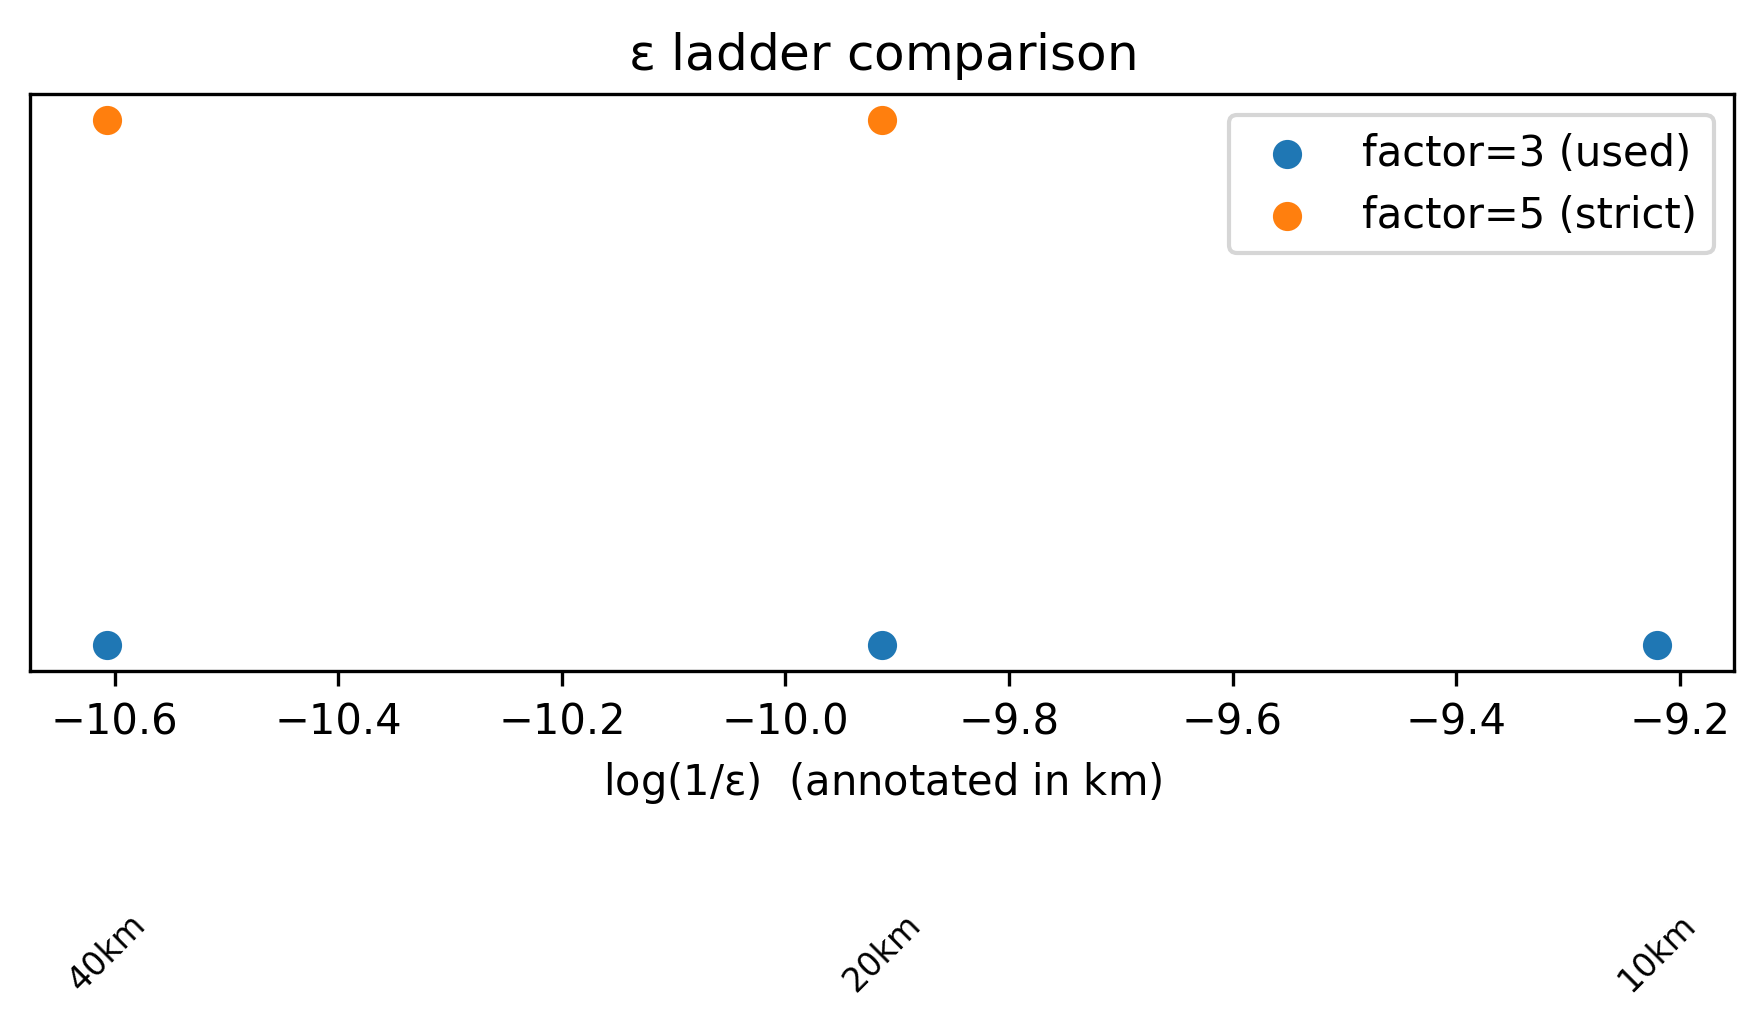

In [9]:
eps_loose, info_loose = build_eps_ladder(
    spacings, gdf.total_bounds, factor=3.0, min_floor=500.0, target_len=6
)
eps_strict, info_strict = build_eps_ladder(
    spacings, gdf.total_bounds, factor=5.0, min_floor=500.0, target_len=6
)

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.scatter(np.log(1 / eps_loose), np.zeros_like(eps_loose), label=f"factor=3 (used)")
ax.scatter(
    np.log(1 / eps_strict), 0.02 * np.ones_like(eps_strict), label=f"factor=5 (strict)"
)
for e in eps_loose:
    ax.text(
        np.log(1 / e),
        -0.01,
        f"{int(e/1000)}km",
        ha="center",
        va="top",
        fontsize=8,
        rotation=45,
    )
ax.set_yticks([])
ax.set_xlabel(r"$\log(1/\epsilon)$  (annotated in km)")
ax.set_title(r"$\epsilon$ ladder comparison")
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
def make_grid_boxes(aoi_bounds, epsilon, theta_deg=0.0, dx=0.0, dy=0.0):
    minx, miny, maxx, maxy = aoi_bounds
    minx -= epsilon
    miny -= epsilon
    maxx += epsilon
    maxy += epsilon

    origin_x = minx + (dx % epsilon)
    origin_y = miny + (dy % epsilon)
    boxes = []
    x = origin_x
    while x < maxx:
        y = origin_y
        while y < maxy:
            boxes.append(box(x, y, x + epsilon, y + epsilon))
            y += epsilon
        x += epsilon

    cx = 0.5 * (aoi_bounds[0] + aoi_bounds[2])
    cy = 0.5 * (aoi_bounds[1] + aoi_bounds[3])
    if abs(theta_deg) > 1e-9:
        boxes = [rotate(b, theta_deg, origin=(cx, cy)) for b in boxes]
    return boxes

In [11]:
def count_hits(line_gdf, boxes):
    g_boxes = gpd.GeoDataFrame(geometry=boxes, crs=line_gdf.crs)
    joined = gpd.sjoin(g_boxes, line_gdf, predicate="intersects", how="inner")
    return joined.index.unique().size

In [12]:
def sweep_counts(line_gdf, epsilons, thetas=(0, 15, 30, 45), n_offsets=6, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    aoi = line_gdf.total_bounds
    records = []
    for e in tqdm(epsilons, desc="ε sweep"):
        for th in thetas:
            for k in range(n_offsets):
                dx = float(rng.uniform(0, e))
                dy = float(rng.uniform(0, e))
                boxes = make_grid_boxes(aoi, e, theta_deg=th, dx=dx, dy=dy)
                N = count_hits(line_gdf, boxes)
                records.append({"epsilon": e, "theta": th, "dx": dx, "dy": dy, "N": N})
    return pd.DataFrame.from_records(records)

In [13]:
coast = gpd.GeoDataFrame(geometry=[unary_union(gdf.geometry)], crs=gdf.crs).explode(
    index_parts=False, ignore_index=True
)
coast = coast.reset_index(drop=True)

In [14]:
eps = np.array(
    [10000.0, 5000.0, 2500.0, 1250.0, 625.0, 312.5, 156.25, 78.125, 39.0625, 19.53125]
)

df_counts = sweep_counts(
    coast, eps, thetas=(0, 15, 30, 45), n_offsets=8, rng_seed=7
)
df_counts.to_csv("data/processed/sg_counts_raw.csv", index=False)
df_counts.head()

ε sweep: 100%|██████████| 10/10 [35:54<00:00, 215.45s/it]


,epsilon,theta,dx,dy,N
0,10000.0,0,6250.954666,8972.138010,12
1,10000.0,0,7756.856902,2252.071900,12
2,10000.0,0,3001.662849,8735.534454,12
3,10000.0,0,52.653046,8212.284184,13
4,10000.0,0,7970.694288,4679.349528,11


In [15]:
agg = df_counts.groupby("epsilon", as_index=False).agg(
    N_mean=("N", "mean"), N_sd=("N", "std"), reps=("N", "size")
)
agg["logN"] = np.log(agg["N_mean"])
agg["log_inv_eps"] = np.log(1.0 / agg["epsilon"])

df_counts["logN"] = np.log(df_counts["N"])
df_counts["log_inv_eps"] = np.log(1.0 / df_counts["epsilon"])

agg

,epsilon,N_mean,N_sd,reps,logN,log_inv_eps
0,19.53125,5212.37500,949.041545,32,8.558791,-2.972016
1,39.06250,2615.71875,474.386003,32,7.869294,-3.665163
2,78.12500,1319.06250,239.274972,32,7.184677,-4.358310
3,156.25000,666.81250,118.865725,32,6.502509,-5.051457
4,312.50000,338.18750,59.023471,32,5.823600,-5.744604
5,625.00000,172.46875,29.344433,32,5.150216,-6.437752
6,1250.00000,89.03125,13.236032,32,4.488987,-7.130899
7,2500.00000,46.68750,4.328730,32,3.843476,-7.824046
8,5000.00000,23.71875,1.197696,32,3.166266,-8.517193
9,10000.00000,11.50000,0.950382,32,2.442347,-9.210340


In [16]:
X = sm.add_constant(agg["log_inv_eps"])
y = agg["logN"]
ols = sm.OLS(y, X).fit(cov_type="HC1")
D_hat = float(ols.params["log_inv_eps"])
D_se  = float(ols.bse["log_inv_eps"])
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logN   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.962e+04
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           2.79e-17
Time:                        00:01:47   Log-Likelihood:                 26.278
No. Observations:                  10   AIC:                            -48.56
Df Residuals:                       8   BIC:                            -47.95
Df Model:                           1                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.4355      0.019    610.068      0.000      11.399      11.472
log_inv_eps     0.9739      0.003    282.176      0.000       0.967       0.981
==============================================================================
Omnibus:                        1.698   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                0.965
Skew:                           0.432   Prob(JB):                        0.617
Kurtosis:                       1.747   Cond. No.                         21.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

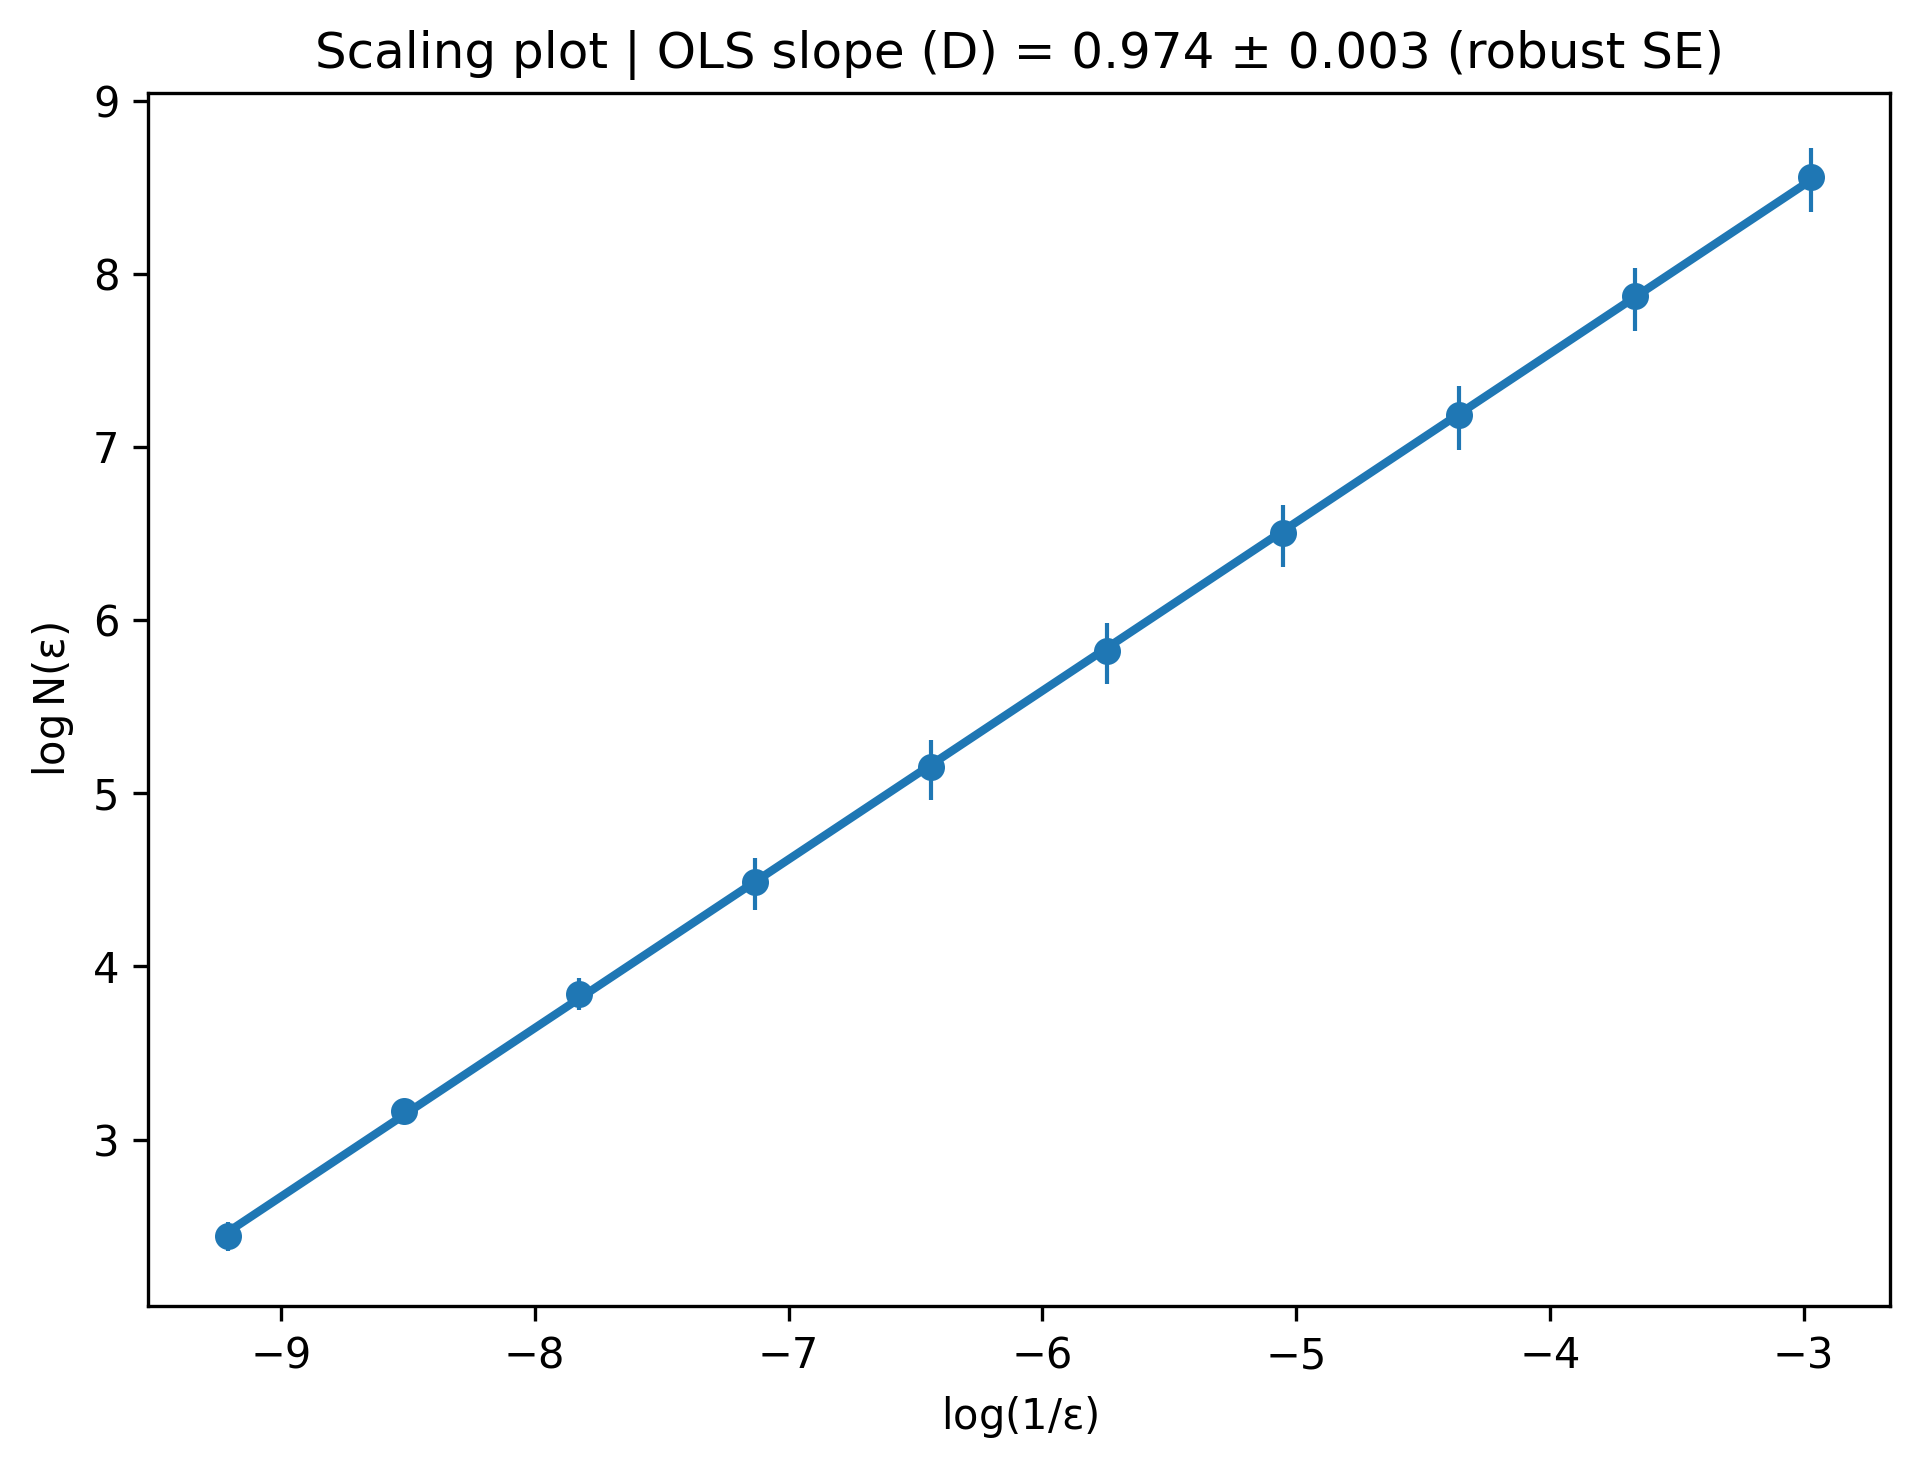

In [17]:
xx = np.linspace(agg["log_inv_eps"].min(), agg["log_inv_eps"].max(), 200)
X_pred = sm.add_constant(xx)
y_pred = ols.predict(X_pred)

y_err_low = np.log(np.clip(agg["N_mean"] - agg["N_sd"], a_min=1e-6, a_max=None))
y_err_high = np.log(agg["N_mean"] + agg["N_sd"])

fig, ax = plt.subplots(figsize=(6.5, 5), dpi=300)
ax.scatter(agg["log_inv_eps"], agg["logN"], s=30)
for xi, yl, yh in zip(agg["log_inv_eps"], y_err_low, y_err_high):
    ax.vlines(xi, yl, yh, linewidth=1)

ax.plot(xx, y_pred, linewidth=2)

ax.set_xlabel(r"$\log(1/\epsilon)$")
ax.set_ylabel(r"$\log N(\epsilon)$")
ax.set_title(f"Scaling plot | OLS slope (D) = {D_hat:.3f} ± {D_se:.3f} (robust SE)")
plt.tight_layout()
plt.savefig("figs/scaling_fit.png", dpi=300)
plt.show()

In [18]:
def bootstrap_slope(df_rep, B=1000, seed=123):
    rng = np.random.default_rng(seed)
    epsilons = sorted(df_rep["epsilon"].unique())
    slopes = []
    for _ in tqdm(range(B), desc="bootstrap"):
        rows = []
        for e in epsilons:
            sub = df_rep[df_rep["epsilon"] == e]
            take = sub.sample(n=len(sub), replace=True, random_state=rng.integers(1e9))
            rows.append(take)
        boot = pd.concat(rows, ignore_index=True)
        boot_agg = boot.groupby("epsilon", as_index=False).agg(N_mean=("N", "mean"))
        boot_agg["logN"] = np.log(boot_agg["N_mean"])
        boot_agg["log_inv_eps"] = np.log(1.0 / boot_agg["epsilon"])
        Xb = sm.add_constant(boot_agg["log_inv_eps"])
        yb = boot_agg["logN"]
        fit = sm.OLS(yb, Xb).fit()
        slopes.append(float(fit.params["log_inv_eps"]))
    return np.array(slopes)

In [19]:
boot_slopes = bootstrap_slope(df_counts, B=600, seed=2025)
ci_low, ci_high = np.percentile(boot_slopes, [2.5, 97.5])
boot_stats = {
    "D_hat": D_hat,
    "boot_mean": float(np.mean(boot_slopes)),
    "CI95": (float(ci_low), float(ci_high)),
}
boot_stats

bootstrap: 100%|██████████| 600/600 [00:03<00:00, 176.77it/s]


{'D_hat': 0.9739428052732093,
 'boot_mean': 0.9739293390465643,
 'CI95': (0.9658188667354524, 0.9813008064568087)}

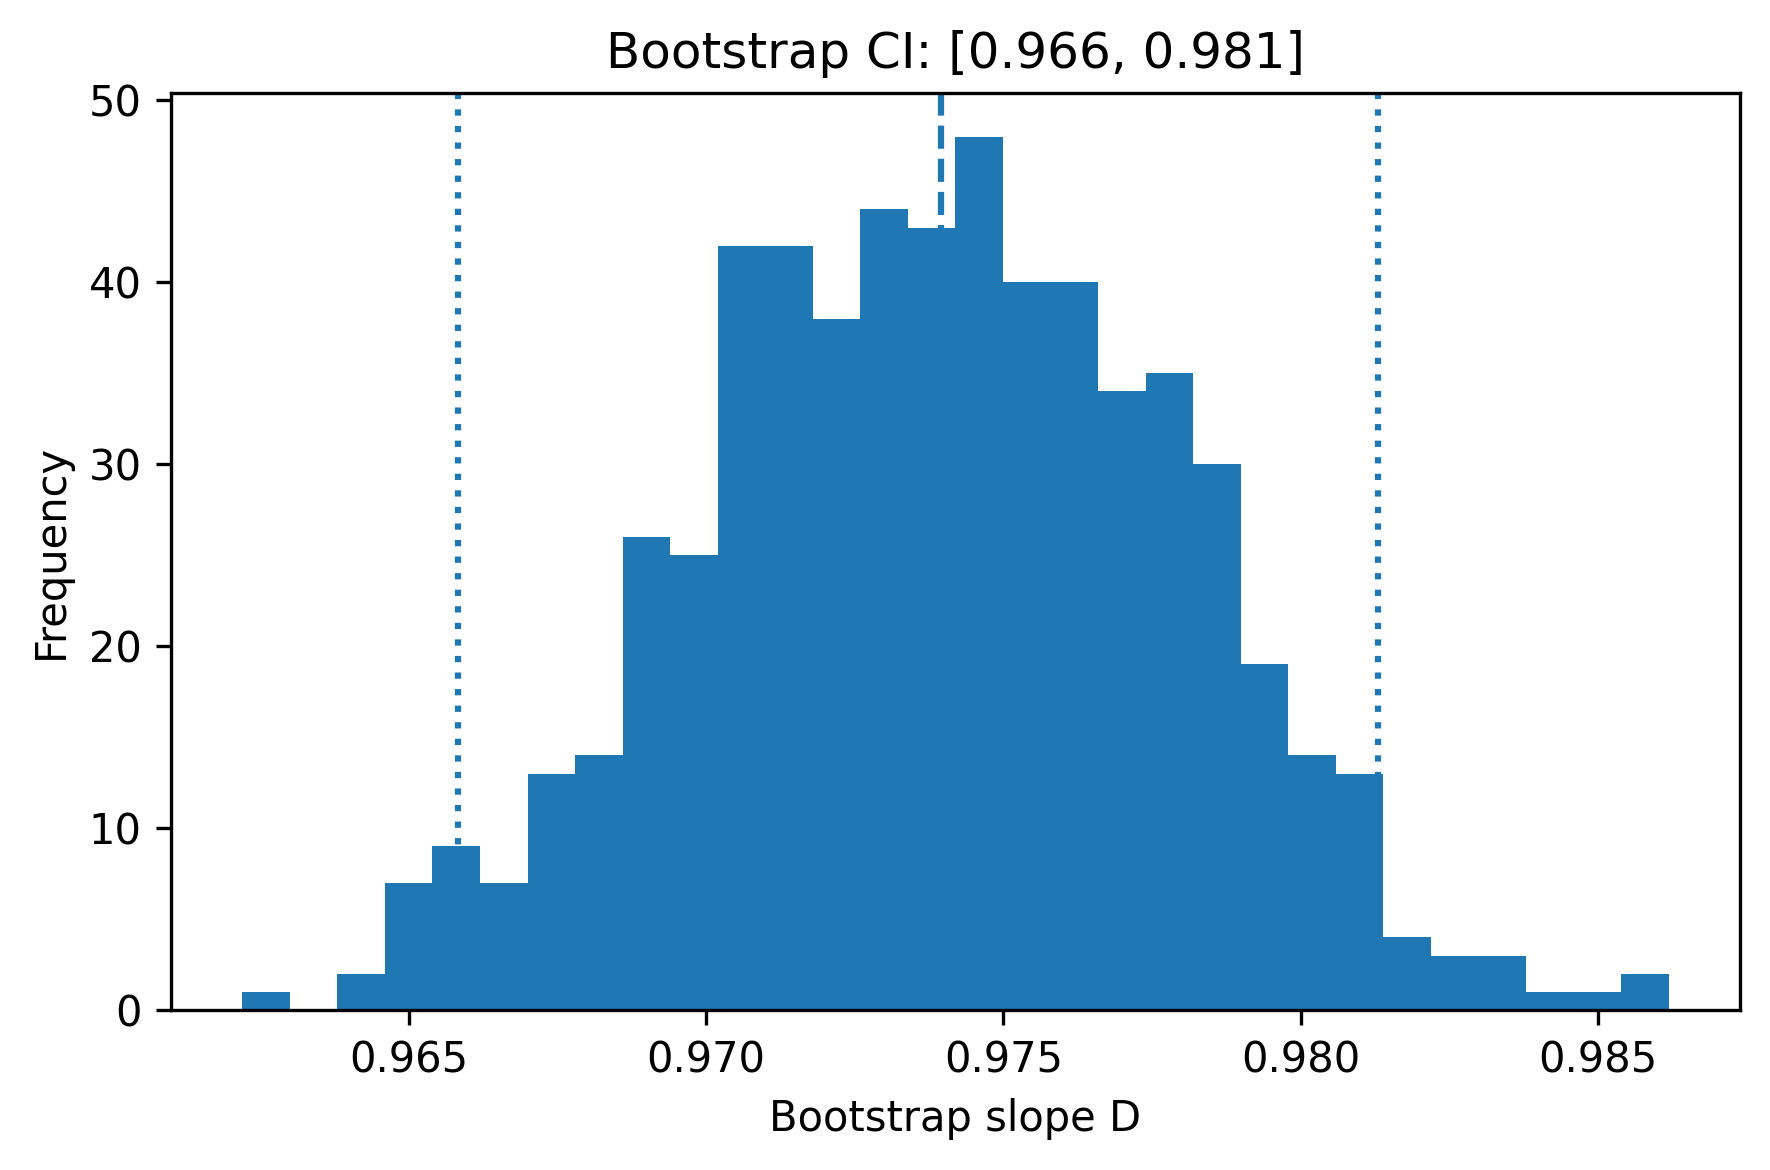

In [20]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.hist(boot_slopes, bins=30)
ax.axvline(D_hat, linestyle="--")
ax.axvline(ci_low, linestyle=":")
ax.axvline(ci_high, linestyle=":")
ax.set_xlabel("Bootstrap slope D")
ax.set_ylabel("Frequency")
ax.set_title(f"Bootstrap CI: [{ci_low:.3f}, {ci_high:.3f}]")
plt.tight_layout()
plt.savefig("figs/bootstrap_D.png", dpi=300)
plt.show()

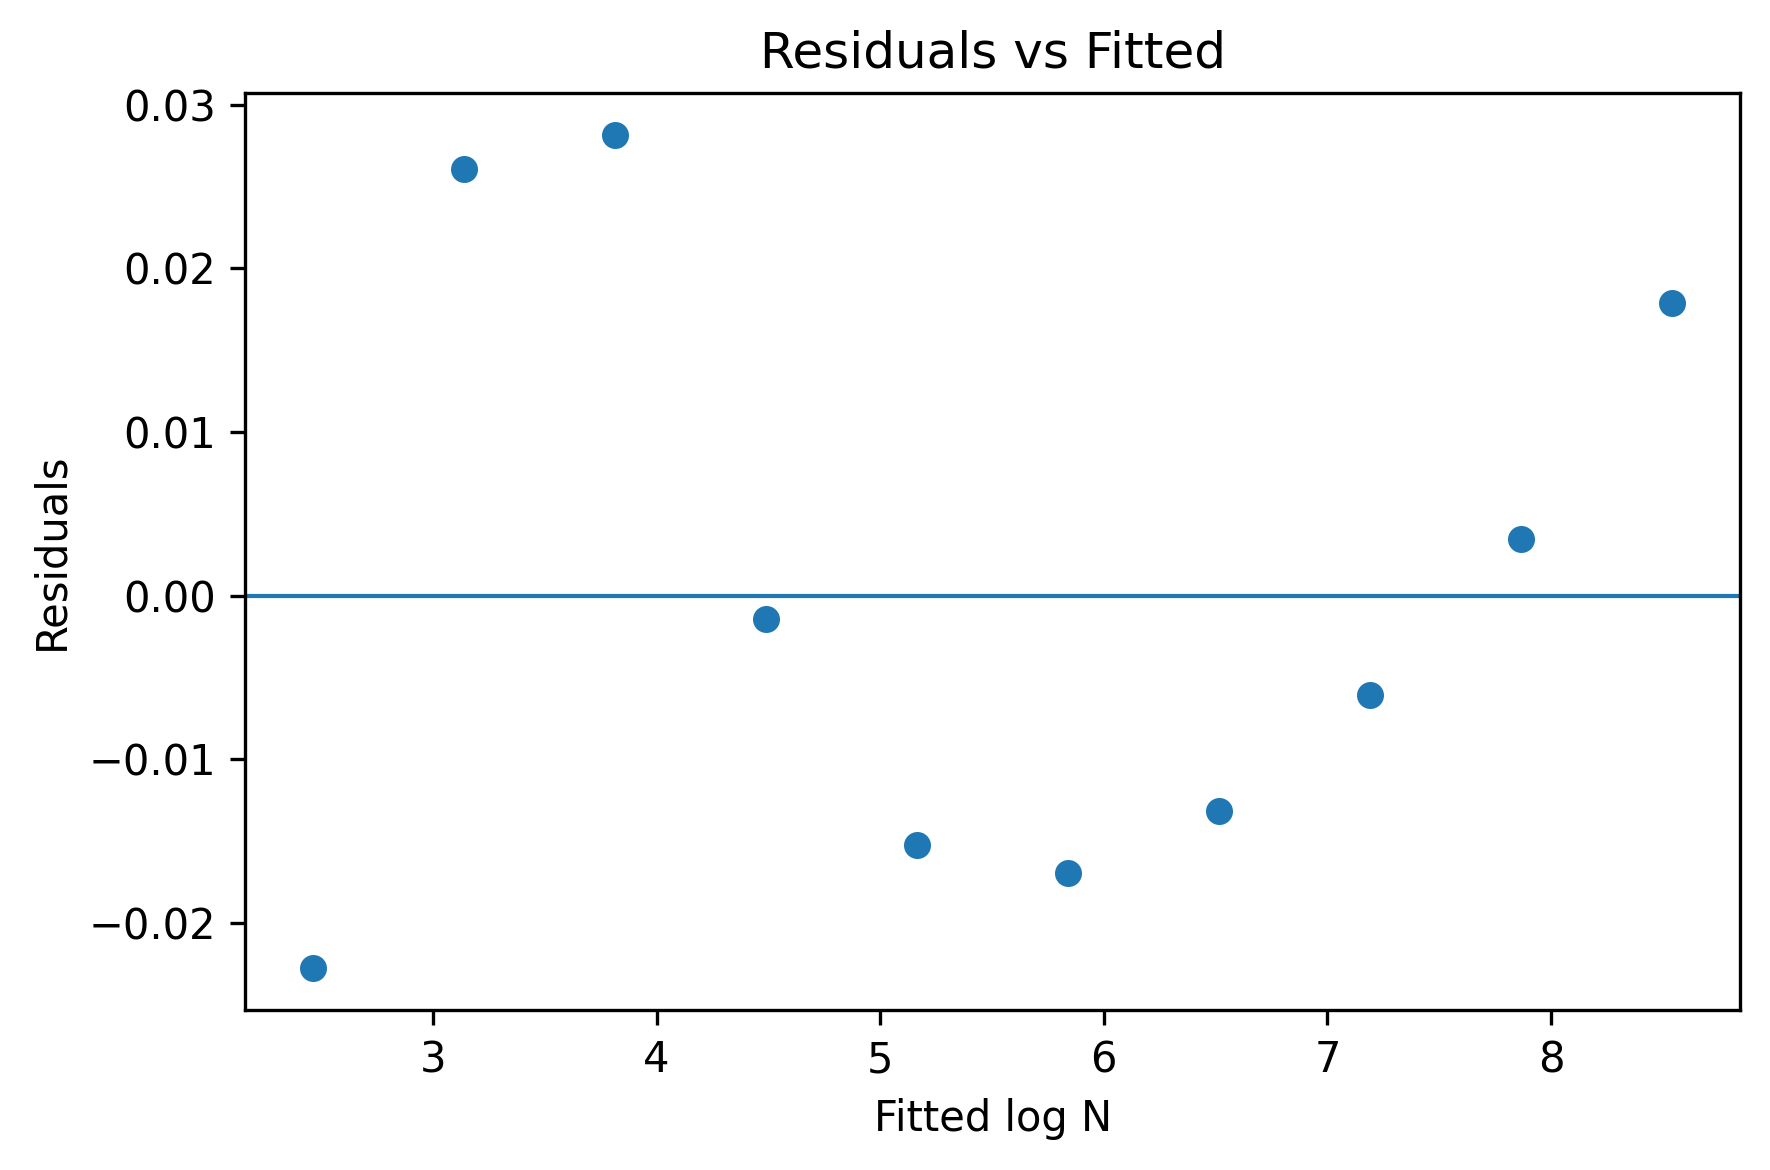

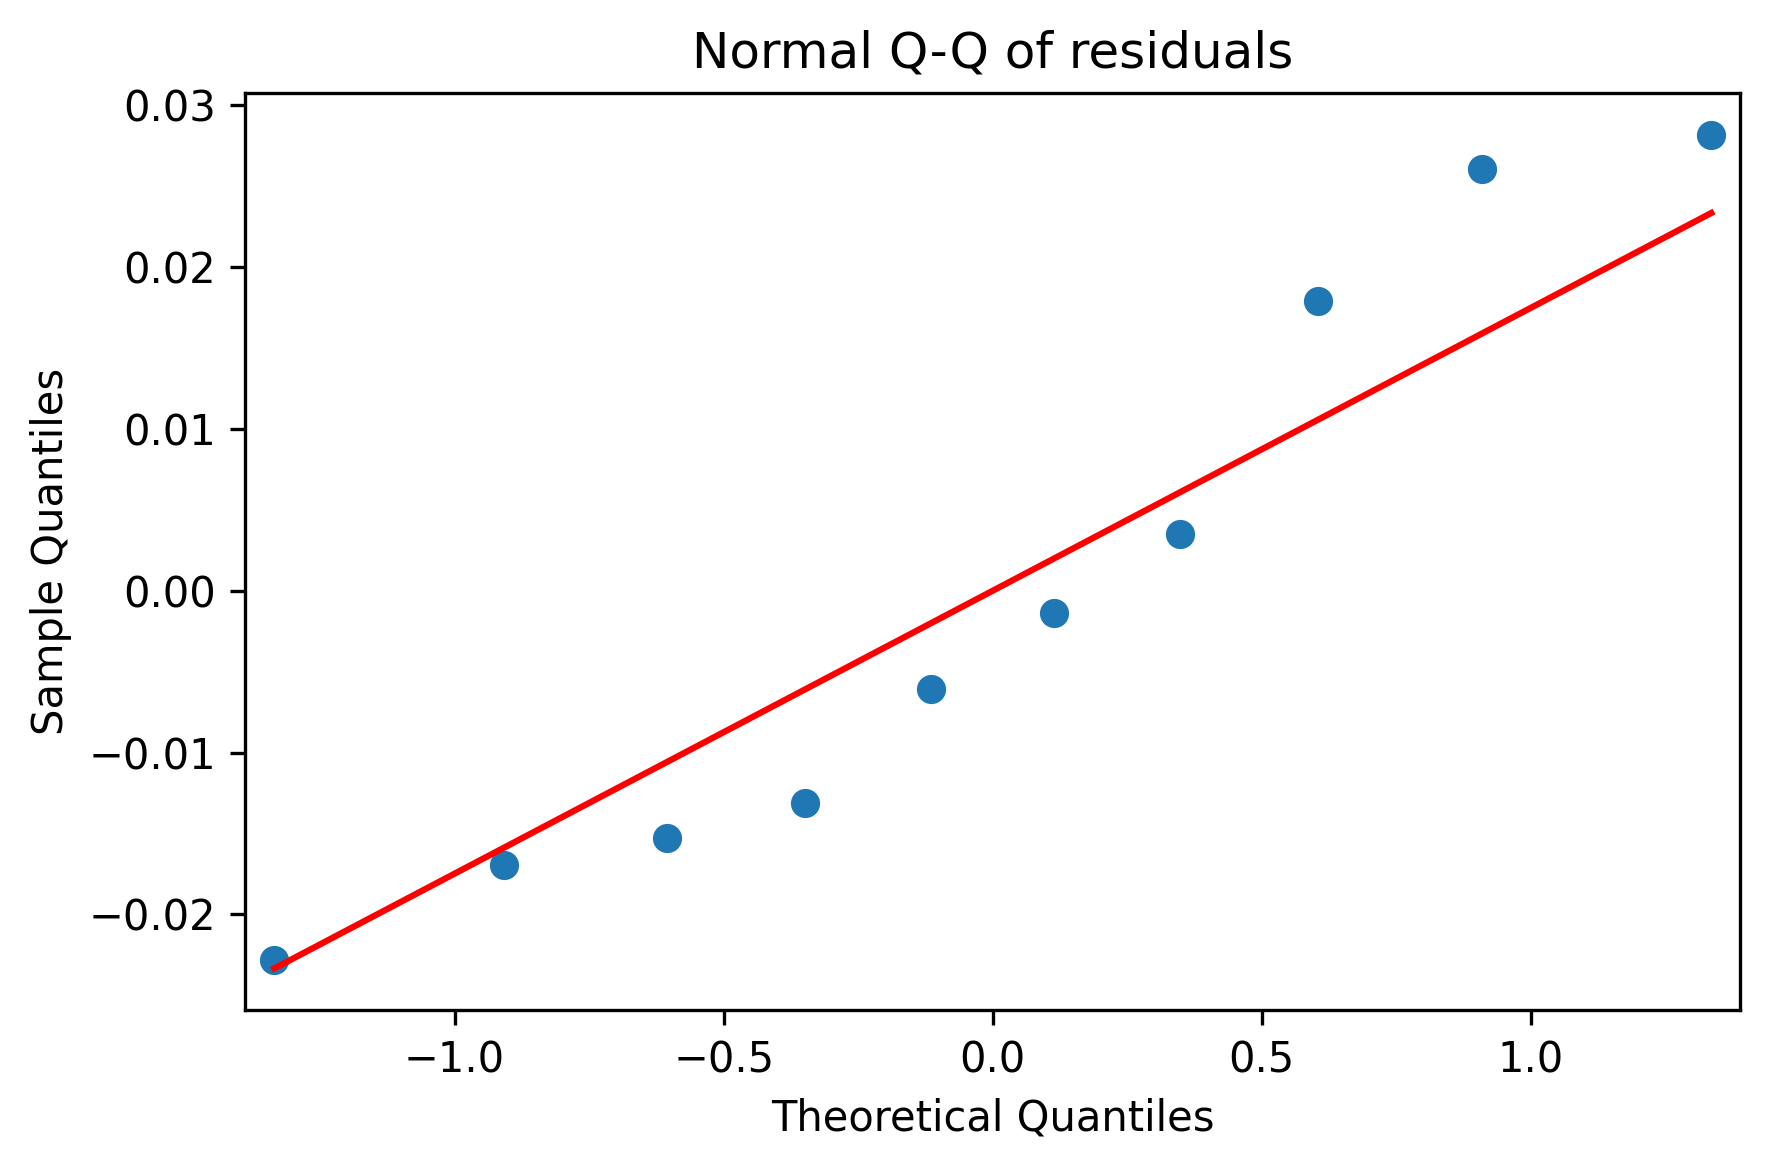

In [21]:
resid = ols.resid
fitted = ols.fittedvalues

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ax.scatter(fitted, resid, s=30)
ax.axhline(0, linewidth=1)
ax.set_xlabel("Fitted log N")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Fitted")
plt.tight_layout()
plt.savefig("figs/residuals_vs_fitted.png", dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
sm.qqplot(resid, line="s", ax=ax)
ax.set_title("Normal Q-Q of residuals")
plt.tight_layout()
plt.savefig("figs/qqplot_residuals.png", dpi=300)
plt.show()

In [22]:
def grid_to_geodf(aoi_bounds, epsilon, theta=0, dx=0, dy=0, crs=None):
    boxes = make_grid_boxes(aoi_bounds, epsilon, theta_deg=theta, dx=dx, dy=dy)
    return gpd.GeoDataFrame(geometry=boxes, crs=crs)

if len(eps) >= 3:
    eps_show = [eps[0], eps[len(eps)//2], eps[-1]]
else:
    eps_show = eps

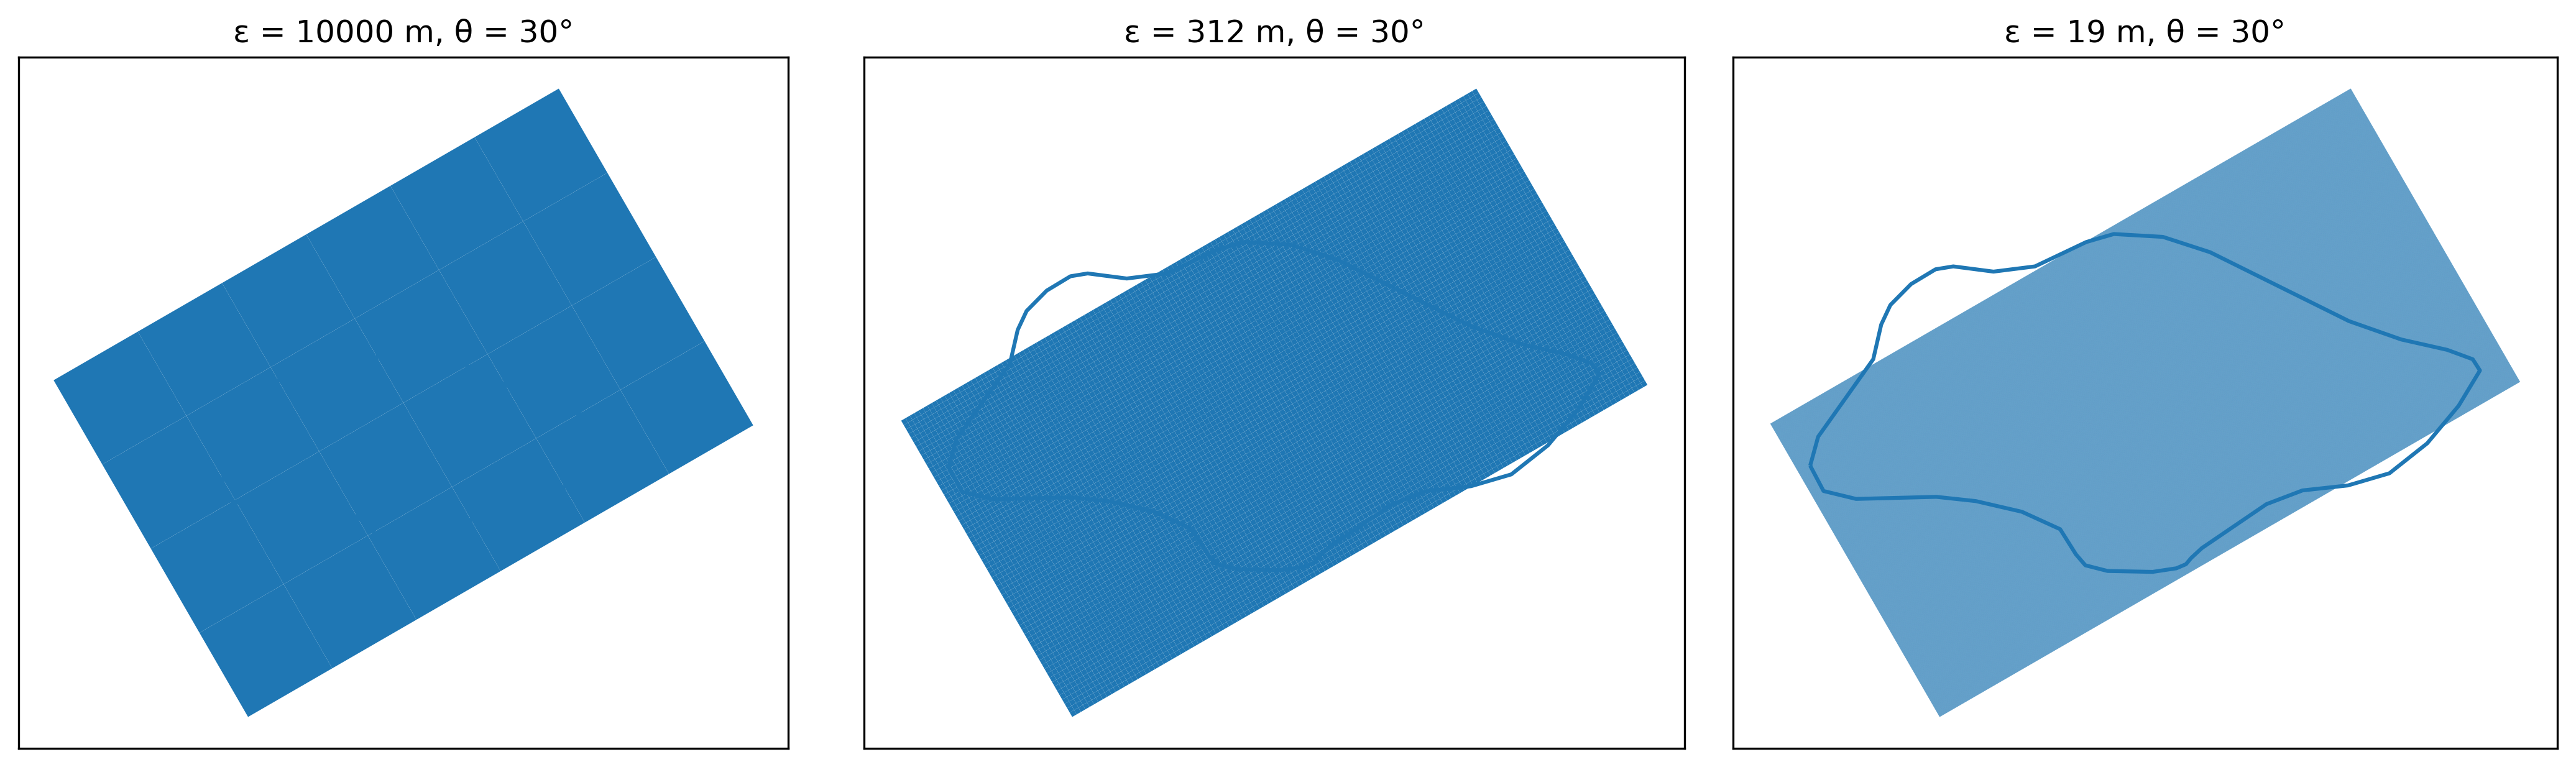

In [23]:
aoi = gdf.total_bounds
rng = np.random.default_rng(11)

fig, axes = plt.subplots(
    1, len(eps_show), figsize=(14, 4), dpi=300, constrained_layout=True
)
for ax, e in zip(axes, eps_show):
    dx = float(rng.uniform(0, e))
    dy = float(rng.uniform(0, e))
    th = float(rng.choice([0, 15, 30, 45]))
    G = grid_to_geodf(aoi, e, theta=th, dx=dx, dy=dy, crs=gdf.crs)
    G.plot(ax=ax, linewidth=0.3)
    gdf.plot(ax=ax, linewidth=1.5)
    ax.set_aspect("equal")
    ax.set_title(f"ε = {int(e)} m, θ = {int(th)}°")
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig("figs/map_panels_grids.png", dpi=300)
plt.show()

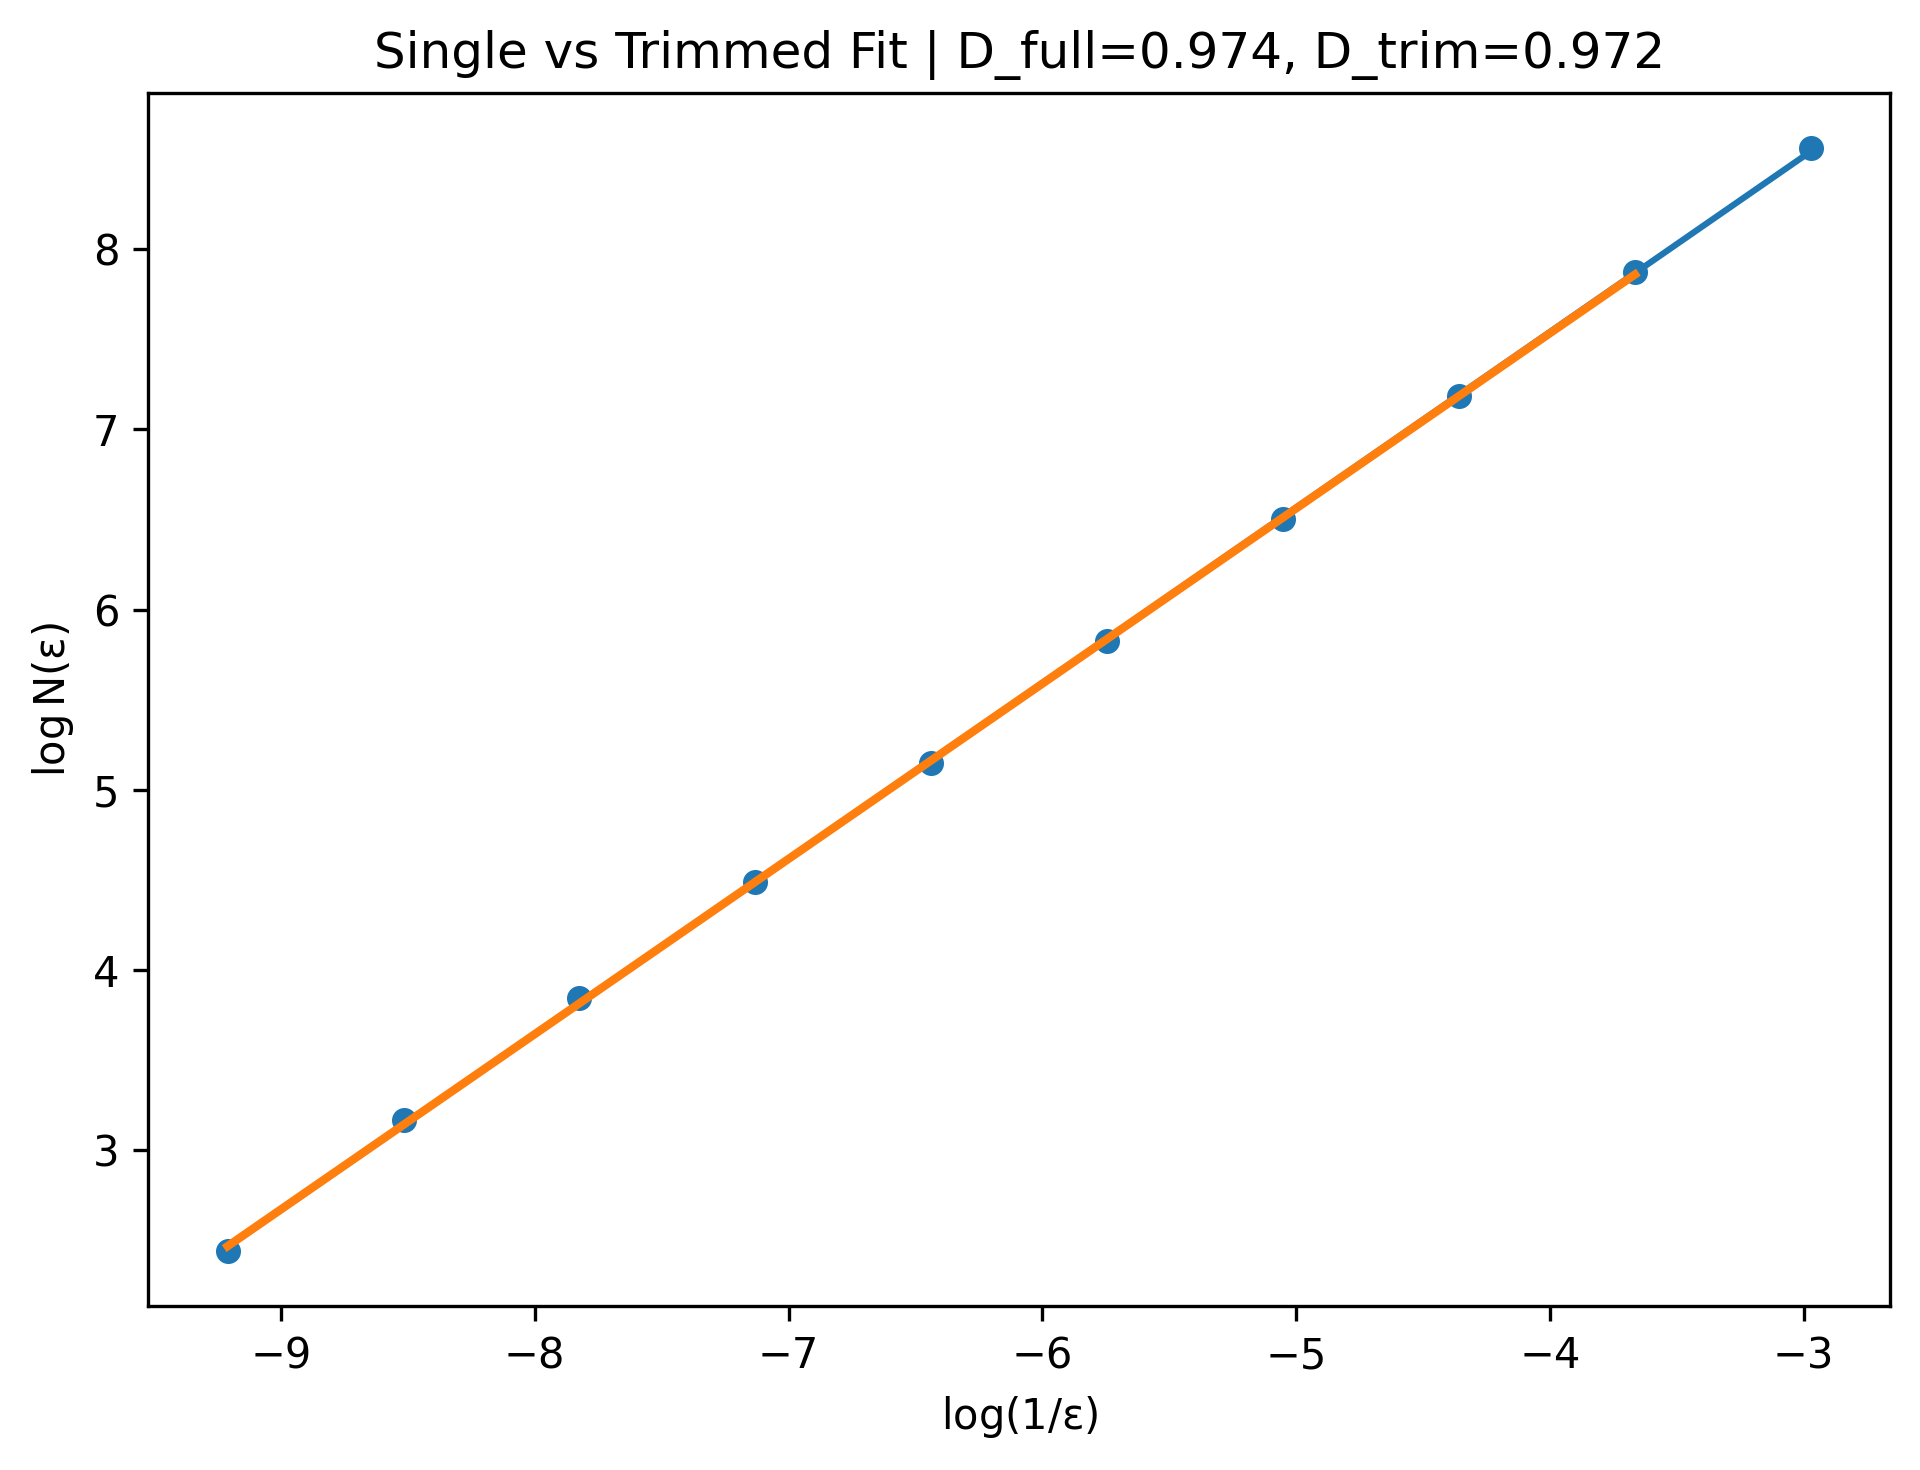

In [24]:
def refit_with_trim(agg_df, trim_small=1):
    df2 = agg_df.sort_values("epsilon", ascending=True).iloc[trim_small:]
    X2 = sm.add_constant(df2["log_inv_eps"])
    y2 = df2["logN"]
    fit2 = sm.OLS(y2, X2).fit(cov_type="HC1")
    return fit2, df2


if len(agg) >= 5:
    fit_trim, agg_trim = refit_with_trim(agg, trim_small=1)
    D_trim = float(fit_trim.params["log_inv_eps"])
    fig, ax = plt.subplots(figsize=(6.5, 5), dpi=300)
    ax.scatter(agg["log_inv_eps"], agg["logN"], s=25)
    ax.plot(xx, y_pred, linewidth=1.5)
    xx2 = np.linspace(agg_trim["log_inv_eps"].min(), agg_trim["log_inv_eps"].max(), 100)
    ax.plot(xx2, fit_trim.predict(sm.add_constant(xx2)), linewidth=2)
    ax.set_xlabel(r"$\log(1/\epsilon)$")
    ax.set_ylabel(r"$\log N(\epsilon)$")
    ax.set_title(f"Single vs Trimmed Fit | D_full={D_hat:.3f}, D_trim={D_trim:.3f}")
    plt.tight_layout()
    plt.savefig("figs/scaling_full_vs_trim.png", dpi=300)
    plt.show()

In [25]:
agg.to_csv("data/processed/sg_counts_agg.csv", index=False)
pd.DataFrame(
    {
        "D_hat": [D_hat],
        "D_se": [D_se],
        "boot_ci_low": [ci_low],
        "boot_ci_high": [ci_high],
    }
).to_csv("data/processed/sg_dimension_summary.csv", index=False)